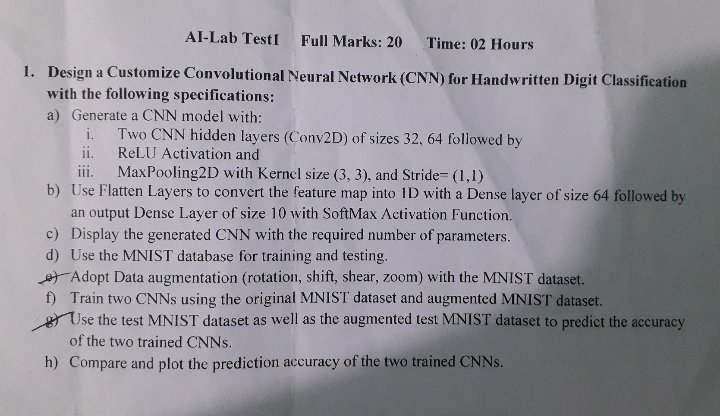

## Import the necessary libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model,clone_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Input


## Load MNIST dataset

In [66]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

## Split train_images into train and validation sets

In [67]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

train_images.shape, test_images.shape, val_images.shape

((54000, 28, 28), (10000, 28, 28), (6000, 28, 28))

## Ploting the Train, Test and Validation dataset

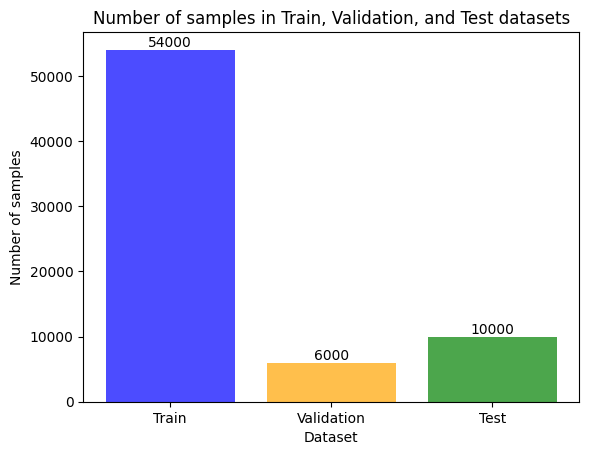

In [68]:
# Calculate lengths of datasets
data = {'Train': len(train_images), 'Validation': len(val_images), 'Test': len(test_images)}
names = list(data.keys())
values = list(data.values())

# Plotting
fig, ax = plt.subplots()
bars = ax.bar(names, values, color=['blue', 'orange', 'green'], alpha=0.7)

ax.set_xlabel('Dataset')
ax.set_ylabel('Number of samples')
ax.set_title('Number of samples in Train, Validation, and Test datasets')

# Add text annotations on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(height),
            ha='center', va='bottom', fontsize=10)

plt.show()

## Plotting sample images from train and test dataset

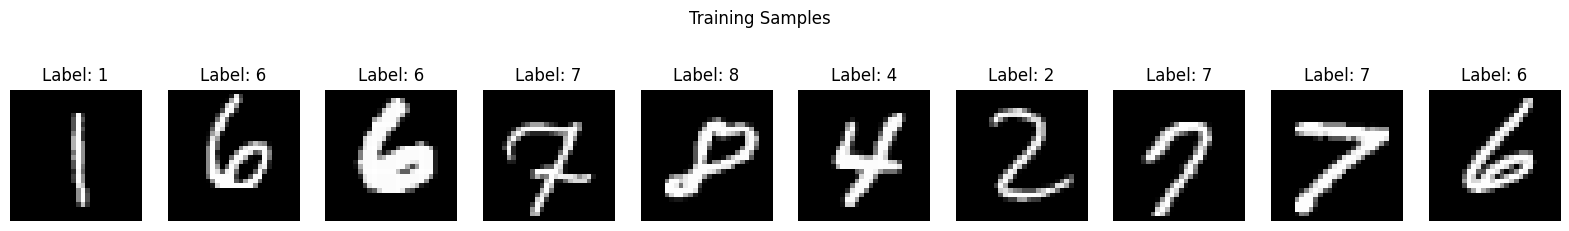

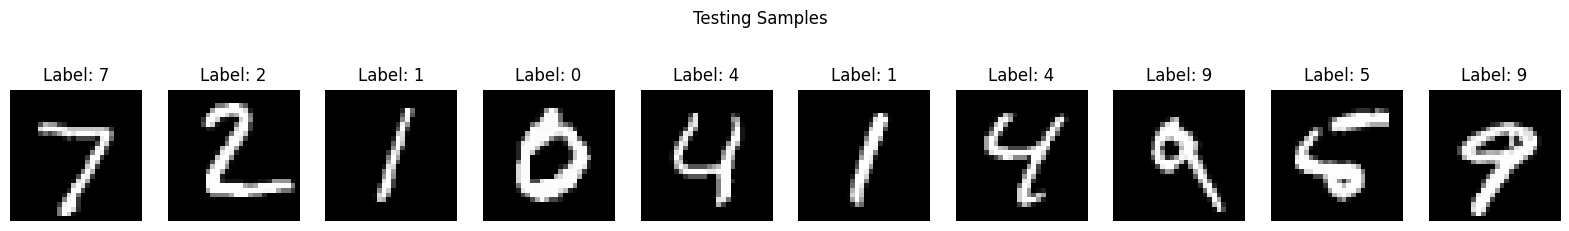

In [69]:
# Function to plot sample images
def plot_samples1(images, labels, title):
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plotting sample images from the training dataset
plot_samples1(train_images, train_labels, 'Training Samples')

# Plotting sample images from the testing dataset
plot_samples1(test_images, test_labels, 'Testing Samples')

## Normalize the pixel values between 0 and 1

In [70]:
train_images, test_images, val_images = train_images / 255.0, test_images / 255.0, val_images / 255.0

## Reshape the images to a single channel (grayscale)

In [71]:
train_images = train_images.reshape((54000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
val_images = val_images.reshape((6000, 28, 28, 1))
train_images.shape, test_images.shape, val_images.shape

((54000, 28, 28, 1), (10000, 28, 28, 1), (6000, 28, 28, 1))

## One hot encode the labels

In [72]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels = to_categorical(val_labels)

## Define data augmentation generator

In [73]:
datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.19,
    height_shift_range=0.17,
    shear_range=0.15,
    zoom_range=0.16,
    horizontal_flip=False
)

## Create data generator for training images


In [74]:
train_generator = datagen.flow(train_images, train_labels, batch_size=64, shuffle=True)
test_generator = datagen.flow(test_images, test_labels, batch_size=64, shuffle=True)

## Generate Augmented Dataset

In [75]:
# Generate Augmented data for train dataset
aug_train_images = []
aug_train_labels = []
for images_batch, labels_batch in train_generator:
    aug_train_images.append(images_batch)
    aug_train_labels.append(labels_batch)
    if len(aug_train_images) * 64 >= len(train_images):
        break

aug_trainX = np.concatenate(aug_train_images)
aug_trainY = np.concatenate(aug_train_labels)

# combine generated train data with original train data
aug_train_images = np.concatenate((train_images, aug_trainX), axis=0)
aug_train_labels = np.concatenate((train_labels, aug_trainY), axis=0)

print(f'Augmented train Images shape: {aug_train_images.shape}, Augmented train Labels shape: {aug_train_labels.shape}')

# Generate Augmented data for test dataset
aug_test_images = []
aug_test_labels = []
for images_batch, labels_batch in test_generator:
  aug_test_images.append(images_batch)
  aug_test_labels.append(labels_batch)
  if len(aug_test_images) * 64 >= len(test_images):
    break

aug_testX = np.concatenate(aug_test_images)
aug_testY = np.concatenate(aug_test_labels)

# combine generated test data with original test data
aug_test_images = np.concatenate((test_images, aug_testX), axis=0)
aug_test_labels = np.concatenate((test_labels, aug_testY), axis=0)

print(f'Augmented test Images shape: {aug_test_images.shape}, Augmented test Labels shape: {aug_test_labels.shape}')

Augmented train Images shape: (108000, 28, 28, 1), Augmented train Labels shape: (108000, 10)
Augmented test Images shape: (20000, 28, 28, 1), Augmented test Labels shape: (20000, 10)


## Plotting sample images from augmented train and augmented test dataset

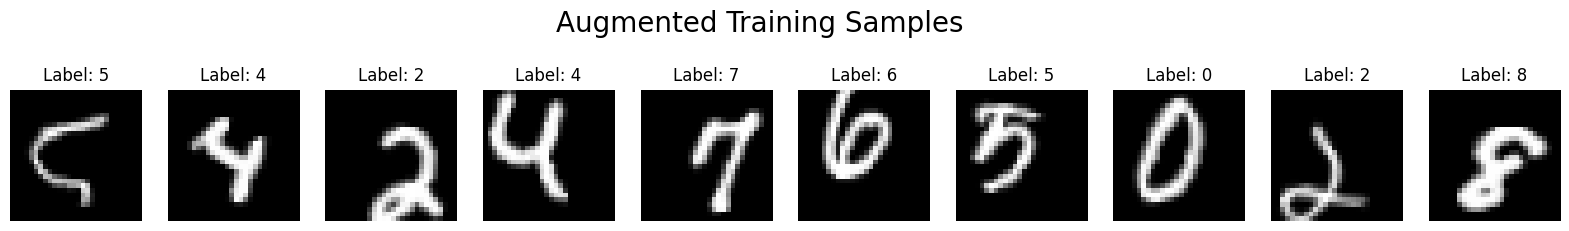

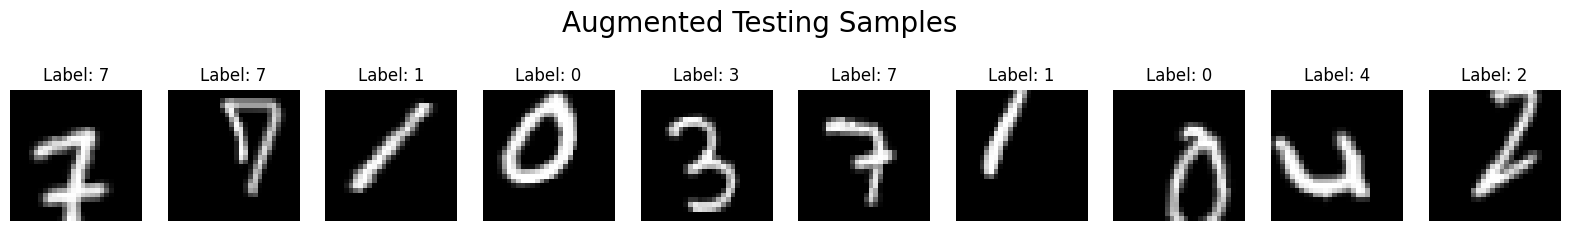

In [76]:
# Function to plot sample images
def plot_samples2(images, labels, title, num_images=10):
    plt.figure(figsize=(20, 3))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f"Label: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.suptitle(title, fontsize=20)
    plt.show()

# Plotting sample images from the training dataset
plot_samples2(aug_trainX, aug_trainY, 'Augmented Training Samples')

# Plotting sample images from the testing dataset
plot_samples2(aug_testX, aug_testY, 'Augmented Testing Samples')

## Define CNN model for Augmented dataset

In [77]:
inputs = Input(shape =(28,28,1), name="input_layer")
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation = 'relu')(inputs)
x = MaxPooling2D()(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation = 'relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(10, activation = 'softmax', name="output_layer")(x)
model1 = Model(inputs,outputs)
model1.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model1

In [78]:
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model1 with data augmentation

In [79]:
batch_size = 64
from keras.callbacks import EarlyStopping

aug_history = model1.fit(aug_train_images, aug_train_labels, epochs=100, batch_size = batch_size, validation_data=(val_images, val_labels), callbacks=[EarlyStopping(patience=3,monitor='val_loss')])

Epoch 1/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8161 - loss: 0.5807 - val_accuracy: 0.9832 - val_loss: 0.0551
Epoch 2/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9644 - loss: 0.1130 - val_accuracy: 0.9850 - val_loss: 0.0474
Epoch 3/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9775 - loss: 0.0702 - val_accuracy: 0.9860 - val_loss: 0.0478
Epoch 4/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9833 - loss: 0.0539 - val_accuracy: 0.9905 - val_loss: 0.0312
Epoch 5/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9872 - loss: 0.0405 - val_accuracy: 0.9887 - val_loss: 0.0363
Epoch 6/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9898 - loss: 0.0312 - val_accuracy: 0.9888 - val_loss: 0.0407
Epoch 7/100
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9916 - loss: 0.0250 - val_accuracy: 0.9897 - val_loss: 0.0424


In [80]:
model1.evaluate(test_images,test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9902 - loss: 0.0284


[0.024998197332024574, 0.9916999936103821]

In [81]:
model1.evaluate(aug_test_images,aug_test_labels)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9881 - loss: 0.0366


[0.056225426495075226, 0.9824000000953674]

# Define model without data augmentation

In [82]:
inputs = Input(shape =(28,28,1), name="input_layer")
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation = 'relu')(inputs)
x = MaxPooling2D()(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation = 'relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
outputs = Dense(10, activation = 'softmax', name="output_layer")(x)
model2 = Model(inputs,outputs)
model2.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the model2

In [83]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Train model2 without data augmentation

In [84]:
history2 = model2.fit(train_images, train_labels, epochs=35, validation_data=(val_images, val_labels), batch_size=batch_size, callbacks=[EarlyStopping(patience=3,monitor='val_loss')])

Epoch 1/35
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8615 - loss: 0.4384 - val_accuracy: 0.9767 - val_loss: 0.0783
Epoch 2/35
844/844 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9795 - loss: 0.0657 - val_accuracy: 0.9885 - val_loss: 0.0440
Epoch 3/35
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9865 - loss: 0.0451 - val_accuracy: 0.9822 - val_loss: 0.0603
Epoch 4/35
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9897 - loss: 0.0336 - val_accuracy: 0.9892 - val_loss: 0.0361
Epoch 5/35
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9920 - loss: 0.0249 - val_accuracy: 0.9898 - val_loss: 0.0355
Epoch 6/35
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9940 - loss: 0.0191 - val_accuracy: 0.9872 - val_loss: 0.0438
Epoch 7/35
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9944 - loss: 0.0163 - val_accuracy: 0.9910 - val_loss: 0.0301
Epoch 8/35
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9958 - loss: 0.0130 - val_accuracy: 0.

In [85]:
model2.evaluate(test_images,test_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9881 - loss: 0.0417


[0.03188851848244667, 0.9908000230789185]

In [86]:
model2.evaluate(aug_test_images,aug_test_labels)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9300 - loss: 0.4208


[1.2853271961212158, 0.7994499802589417]

## Training and validation loss with data Augmentation

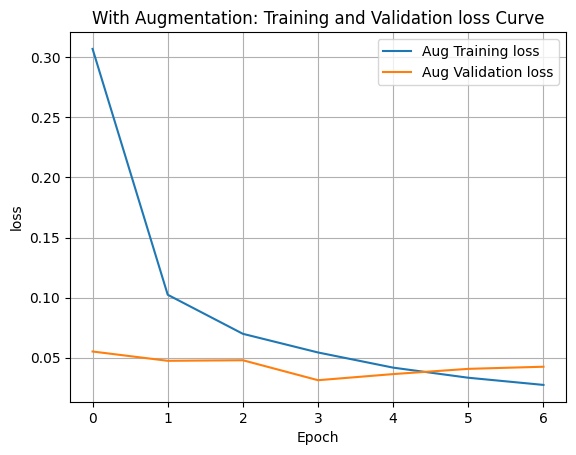

In [87]:
plt.plot(aug_history.history['loss'], label='Aug Training loss')
plt.plot(aug_history.history['val_loss'], label='Aug Validation loss')

plt.title('With Augmentation: Training and Validation loss Curve')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

## Training and validation loss without data Augmentation

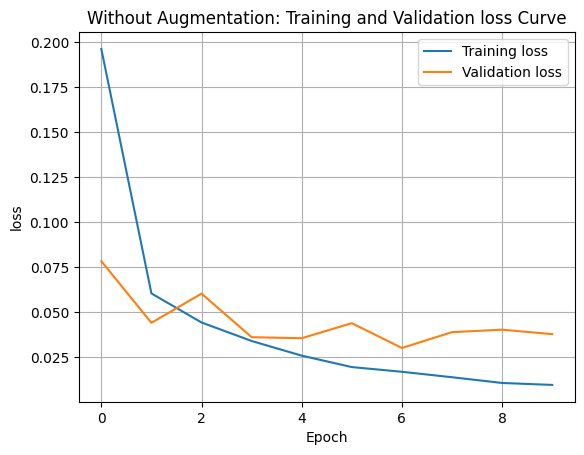

In [88]:
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')

plt.title('Without Augmentation: Training and Validation loss Curve')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.show()

## Training and validation accuracy curve with data aumentation




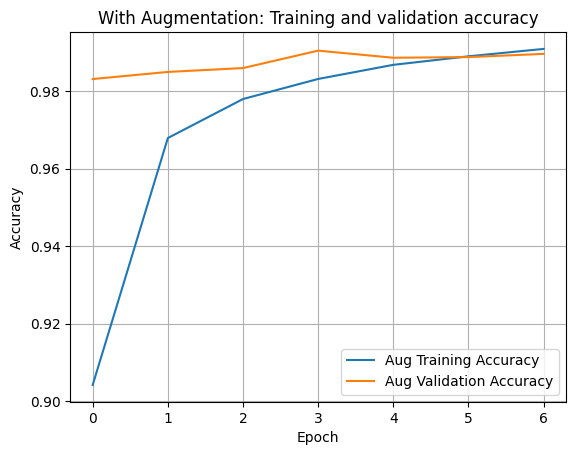

In [89]:
plt.plot(aug_history.history['accuracy'], label='Aug Training Accuracy')
plt.plot(aug_history.history['val_accuracy'], label='Aug Validation Accuracy')

plt.title('With Augmentation: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

## Training and validation accuracy curve without data augmentation

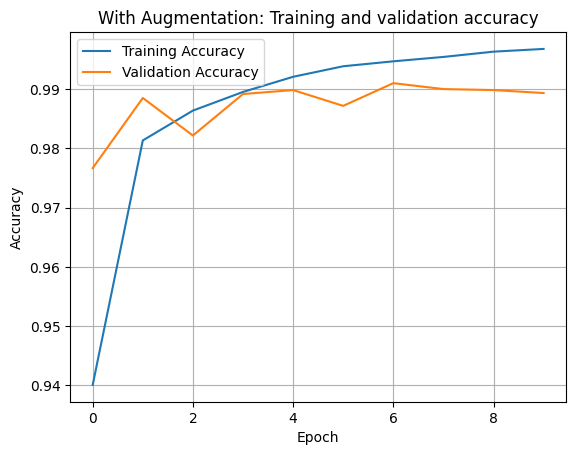

In [90]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')

plt.title('With Augmentation: Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

# Function to calculate accuracy

In [91]:
def get_accuracy(model, x_data, y_data, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    loss, accuracy = model.evaluate(dataset, verbose=0)
    return accuracy

# Calculate accuracies for different scenarios


In [92]:
i_result = model1.evaluate(test_images, test_labels, verbose=0)
ii_result = model1.evaluate(aug_test_images, aug_test_labels, verbose=0)
iii_result = model2.evaluate(test_images, test_labels, verbose=0)
iv_result = model2.evaluate(aug_test_images, aug_test_labels, verbose=0)

# Print the accuracies
print("Augmented Model Accuracy:")
print("i.   Test Score with Original Data : ", i_result[1])
print("ii.  Test Score with Augmented Data: ", ii_result[1])

print("\nNo Augmented Model Accuracy:")
print("iii. Test Score with Original Data : ", iii_result[1])
print("iv.  Test Score with Augmented Data: ", iv_result[1])

Augmented Model Accuracy:
i.   Test Score with Original Data :  0.9916999936103821
ii.  Test Score with Augmented Data:  0.9824000000953674

No Augmented Model Accuracy:
iii. Test Score with Original Data :  0.9908000230789185
iv.  Test Score with Augmented Data:  0.7994499802589417


## Function to display misclassified images

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Total misclassified images: 83


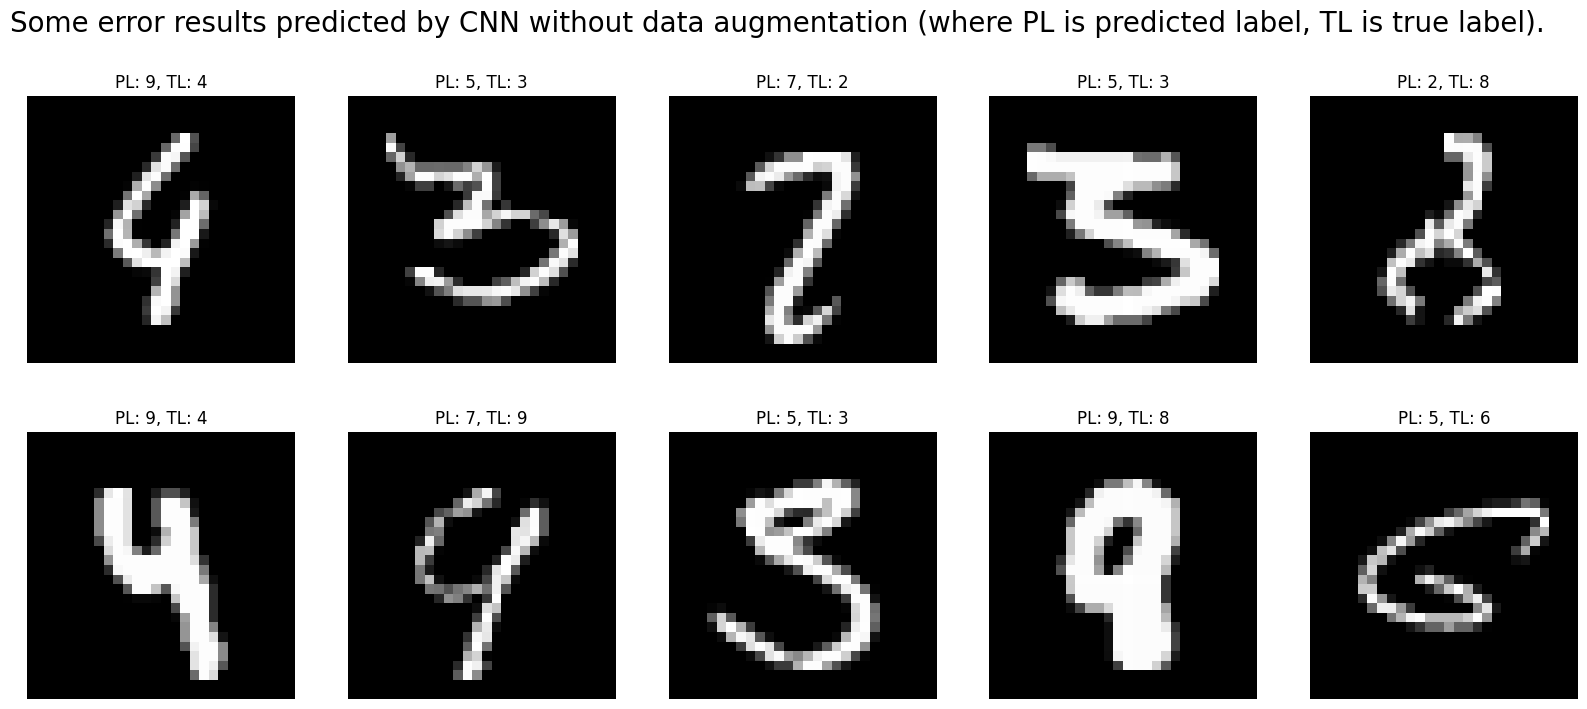

In [93]:
def display_misclassified(model, images, labels, num_images=10):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    misclassified_indices = np.where(predicted_labels != true_labels)[0]

    print(f"Total misclassified images: {len(misclassified_indices)}")

    if len(misclassified_indices) > 0:
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        fig.suptitle('Some error results predicted by CNN without data augmentation (where PL is predicted label, TL is true label).', fontsize=20)
        axes = axes.flatten()

        for i, ax in enumerate(axes):
            if i < len(misclassified_indices):
                idx = misclassified_indices[i]
                ax.imshow(images[idx].reshape(28, 28), cmap='gray')
                ax.set_title(f"PL: {predicted_labels[idx]}, TL: {true_labels[idx]}")
                ax.axis('off')
            else:
                ax.axis('off')
        plt.show()

# Display some misclassified images from the test set
display_misclassified(model1, test_images, test_labels)
